[<img src="data/photutils_banner.svg" width=300>](http://photutils.readthedocs.io/en/stable/index.html)

# Source Detection with `photutils`
---

##### What is source detection?
In order to do photometry on astronomical image data, one must first determine the locations of the sources in the image. Source detection methods find sources algorithmically, by looking for regions of an image where the signal from a source is statistically higher than the signal from background noise. Some algorithms search for sources whose profiles match specific data models, such as a 2-D Gaussian, while others simply look for local maxima.

The `photutils` package provides a variety of tools that use different detection algorithms to locate sources in an image.

##### What does this tutorial include?
This tutorial covers different tools for source detection with `photutils`, including the following methods:
* Source Detection with `DAOStarFinder`
* Source Detection with `IRAFStarFinder`
* Source Detection with `find_peaks`
* Image Segmentation and Deblending

The methods demonstrated here are available in narrative form within the `photutils.detection` [documentation](http://photutils.readthedocs.io/en/stable/detection.html) and `photutils.segmentation` [documentation](http://photutils.readthedocs.io/en/stable/segmentation.html).

<div class="alert alert-block alert-warning">**Important:** Before proceeding, please be sure to install or update your [AstroConda](https://astroconda.readthedocs.io) distribution. This notebook may not work properly with older versions of AstroConda.</div>

---

## Import necessary packages

First, let's import packages that we will use to perform arithmetic functions and visualize data:

In [1]:
import numpy as np
from astropy.io import fits
from astropy.stats import sigma_clipped_stats, SigmaClip
from astropy.visualization import ZScaleInterval, ImageNormalize
from photutils import make_source_mask
from photutils.background import Background2D, MedianBackground
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
% matplotlib inline

Let's also define some `matplotlib` parameters, to make sure our plots look nice. (See [here](https://matplotlib.org/users/customizing.html) to learn more about customizing `matplotlib`.)

In [2]:
matplotlib.rc('font', family='serif', weight='light', size=12)
matplotlib.rc('mathtext', bf='serif:normal')
matplotlib.rc('axes', titlesize=18, titlepad=12, labelsize=16)
matplotlib.rc('xtick', labelsize=14)
matplotlib.rc('ytick', labelsize=14)

## Retrieve data

We have place the data for this tutorial in the github repository, for easy access. The data were originally retrieved from the STScI archive: https://archive.stsci.edu/prepds/udf/udf_hlsp.html.

In [3]:
with fits.open('data/h_udf_wfc_v_drz_img.fits') as hdulist:
    v_data = hdulist[0].data

Let's look at the data:

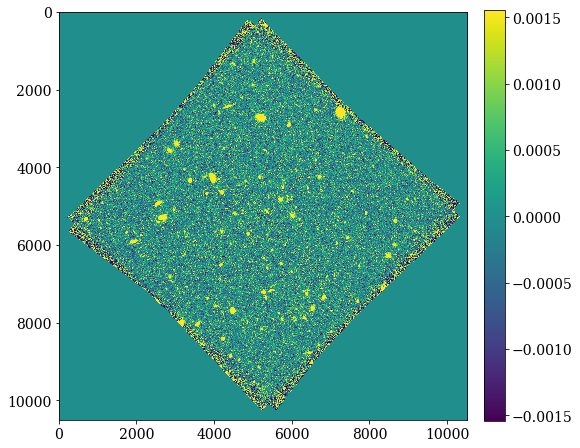

In [4]:
fig, ax1 = plt.subplots(1, 1, figsize=(8, 8))

clim = (0, 1e-2)

v_data_plot = np.copy(v_data)
v_data_plot[v_data_plot <= 0] = 1e-10

norm_image = ImageNormalize(v_data, interval=ZScaleInterval())
fitsplot = ax1.imshow(v_data, norm=norm_image)#, clim=clim)

plt.colorbar(fitsplot, fraction=0.046, pad=0.04)

plt.show()

---
## Source Detection with `DAOStarFinder`

With the `DAOStarFinder` class, `photutils` provides users with an easy application of the popular [DAOFIND](http://stsdas.stsci.edu/cgi-bin/gethelp.cgi?daofind) algorithm ([Stetson 1987, PASP 99, 191](http://adsabs.harvard.edu/abs/1987PASP...99..191S)), originally developed at the Dominion Astrophysical Observatory. 

This algorithm detects sources by:
* Searching for local maxima
* Selecting only sources with peak amplitude above a defined threshold
* Selecting sources with sizes and shapes that match a 2-D Gaussian kernel

It returns:
* Location of the source centroid
* Parameters reflecting the source's sharpness and roundness

In [6]:
mask = [v_data == 0]
mean, median, stddev = sigma_clipped_stats(v_data[~mask])

In [25]:
from photutils import DAOStarFinder
daofind = DAOStarFinder(fwhm=7.0, threshold=5.*stddev)
sources = daofind(v_data - median)    
print(sources)

  id    xcentroid     ycentroid   ...      flux           mag      
----- ------------- ------------- ... ------------- ---------------
    1 5201.49828598 191.017765626 ... 1.62849237648 -0.529464324567
    2 5194.11960549 190.030431303 ... 1.36849179306 -0.340605493151
    3 5199.74044352 202.418903468 ... 1.52473368273 -0.457984985891
    4 5203.10770512 209.661789903 ... 1.20340294149  -0.20102767177
    5 5173.75650313 212.843655154 ... 1.94233848379 -0.720812287452
    6 5189.12321195 216.990707812 ... 1.09905631776 -0.102549867698
    7 5197.72148146 218.664031138 ... 1.72859687601 -0.594234309474
    8 5216.91725145 225.505651139 ... 1.39386776294 -0.360553934852
    9 5164.67361196 226.609460933 ... 1.73951175848 -0.601068421922
   10 5194.82543622 227.661914309 ... 1.92219249467 -0.709492192965
  ...           ...           ... ...           ...             ...
20078 5224.54416107 10226.0383851 ... 2.61590566295  -1.04405519508
20079 5198.85670325  10227.853269 ... 1.88639588

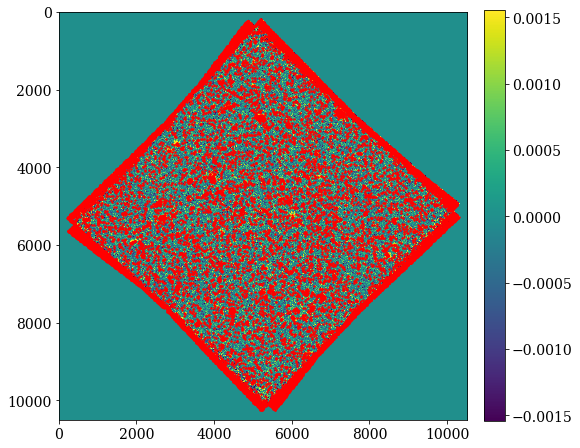

In [26]:
fig, ax1 = plt.subplots(1, 1, figsize=(8, 8))

clim = (0, 1e-2)

v_data_plot = np.copy(v_data)
v_data_plot[v_data_plot <= 0] = 1e-10

norm_image = ImageNormalize(v_data, interval=ZScaleInterval())
fitsplot = ax1.imshow(v_data, norm=norm_image)#, clim=clim)

ax1.scatter(sources['xcentroid'], sources['ycentroid'], c='red', s=2)

plt.colorbar(fitsplot, fraction=0.046, pad=0.04)

plt.show()

## Source Detection with `IRAFStarFinder`

Similarly to `DAOStarFinder`, `IRAFStarFinder` is a class that implements a pre-existing algorithm that is widely used within the astronomical community. This class uses the [`starfind`](http://stsdas.stsci.edu/cgi-bin/gethelp.cgi?starfind) algorithm that was originally part of IRAF.

`IRAFStarFinder` is fundamentally similar to `DAOStarFinder` in that it detects sources by finding local maxima above a certain threshold that match a Gaussian kernel. However, `IRAFStarFinder` differs in the following ways:
* Allows users to specify an elliptical Gaussian kernel
* Uses image moments to calculate the centroids, roundness, and sharpness of objects

## Source Detection with `find_peaks`

For more general source detection cases that do not require rigorous comparison with models, `photutils` offers the `find_peaks` function. This function simply finds sources by identifying local maxima above a given threshold and separated by a given distance. Unlike the previous detection algorithms, `find_peaks` does not necessarily calculate objects' centroids. Unless the `subpixel` argument is set to `True`, `find_peaks` will return just the integer value of the peak pixel for each source.

This algorithm is particularly useful for identifying non-stellar sources or heavily distorted sources in image data.

## Image Segmentation and Deblending

In [ ]:
from photutils import detect_sources
npixels = 5
segm = detect_sources(data, threshold, npixels)

In [ ]:
# plot the segmentation image
from photutils.utils import random_cmap
rand_cmap = random_cmap(random_state=12345)

plt.imshow(segm, cmap=rand_cmap)
print('Found {0} sources'.format(segm.max))

In [ ]:
from photutils import deblend_sources
segm2 = deblend_sources(data, segm, npixels, filter_kernel=kernel,
                        contrast=0.001, nlevels=32)
plt.imshow(segm2, cmap=rand_cmap)
print('Found {0} sources'.format(segm2.max))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 8))
ax1.imshow(scale_image(data, scale='sqrt', percent=99.5))
ax2.imshow(segm2, cmap=rand_cmap)

---
## Exercises

##### To continue with this `photutils` tutorial, go on to the [aperture photometry](03_photutils_aperture_photometry.ipynb) or [PSF photometry notebook](04_photutils_psf_photometry.ipynb).

---
<i>May 2018

Author: Lauren Chambers (lchambers@stsci.edu)

For more examples and details, please visit the [photutils](http://photutils.readthedocs.io/en/stable/index.html) documentation.</i>